<h1 style=text-align:center;>Learning from neighbors</h1>

El modelo de este notebook fue desarrollado principalmente en:
- Bala y Goyal (1998) - Learning from Neighbors
- Zollman (2007) - The Communication Structure of Epistemic Communities
- Zollman (2010) - The Epistemic Benefit of Transient Diversity


Otros recursos online para mirar respecto de este modelo:
- [Zollman Effect en Formal Epistemology (SEP)](https://plato.stanford.edu/entries/formal-epistemology/#TheZolEff): una buena descripción del modelo por Jonathan Weisberg.
- [Repo de Formal Epistemology (SEP)](https://github.com/jweisber/sep-sen): implementación de algunos de los modelos de la entrada Formal Epistemology de la SEP hecha por Weisberg.

El modelo consiste en una red de agentes, donde cada agente representa a un científico. En cada turno, los agentes eligen entre dos acciones $A$ y $B$ en base a su creencia sobre qué acción es mejor. En particular, cada agente tiene asociado un número $x \in [0,1]$, representando su creeencia en que la acción $B$ es mejor que la acción $A$.

Los agentes actualizan su creencia $x$ a partir de dos fuentes de información: en primer lugar, observan los *outcomes* de las acciones que eligieron; segundo, también toman en consideración la información recolectada por sus vecinos.

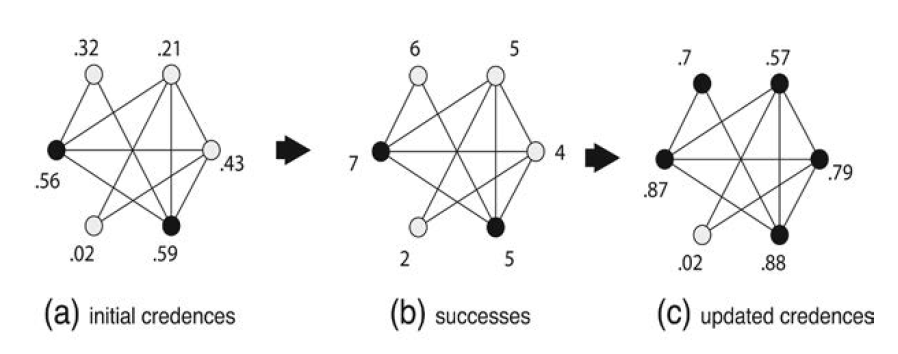

Esta imagen muestra un ejemplo de cómo se ve el proceso.
1. Imagen (a): cada agente tiene una creencia $x \in [0,1]$. Los nodos para los que $x < 0.5$ realizarán la acción $A$ (nodos coloreados de blanco), y los demás realizarán la acción $B$ (nodos negros).
2. Imagen (b): cada agente obtiene un *outcome* en base a la acción que ejecutó.
3. Imagen (c): cada agente actualiza su creencia usando la regla de Bayes sobre la base de los *outcomes* que obtuvo y los *outcomes* obtenidos por sus vecinos.

Dado el agente con creencia $.56$ (que denotaré $a$), puedo establecer lo siguiente:
- $P_a(H) = .56$, y $P_a(H^C) = .44$
- $E = 7$

Además, recuerdo las siguientes reglas:

Probabilidad condicional

$$
P(B|A)= \frac{P(A \cap B)}{P(A)}
$$

Teorema de Bayes:

$$
P(H|E) = \frac{P(E|H)P(H)}{P(E|H)P(H) + P(E|H^C)P(H^C)} = \frac{P(E|H)P(H)}{P(E)}
$$

Update bayesiano en el código de Weisberg:

$$
1 + (1 - P(H))\left( \frac { 0.5 - \epsilon }{ 0.5 + \epsilon } \right) ^{2k - n} / P(H)
$$

donde $n$ es el total de experimentos realizados por un agente y sus vecinos, y $k$ el total de éxitos en esos experimentos.

$$
1 + (1 - P(H))\left( \frac { 1-p }{ p } \right) ^{2k - n} / P(H)
$$

In [66]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

En Zollman (2007), se presenta un modelo de base en el que todos los agentes acceden a los resultados de todos los experiemntadores. Ese modelo puede implementarse de la siguiente manera:

In [52]:
class Agent:
    def __init__(self, credence):
        self.credence = credence
        
    def bayesian_update(self, p_e_h, p_e_ch):
        self.credence = (p_e_h * self.credence) / ((p_e_h * self.credence) + (p_e_ch * (1-self.credence)))
        
class Simulation:
    def __init__(self, agents):
        self.agents = agents
    
    @property
    def experimenters(self):
        return [agent for agent in self.agents if agent.credence>.5]
    
    @property
    def agent_credences(self):
        return [agent.credence for agent in self.agents]
    
    def step(self):
        for agent in self.agents:
            for experimenter in self.experimenters:
                agent.bayesian_update(p_e_h, p_e_ch)

In [53]:
p_e_h = .4
p_e_ch = .6
credences = [.33, .49, .51, .66]
agents = [Agent(credence) for credence in credences]
sim = Simulation(agents)

sim.step()

In [54]:
sim.agent_credences

[0.17959183673469387,
 0.29923664122137406,
 0.3162790697674419,
 0.5641025641025642]

# Modelo completo

### Red Watts Strogatz

El modelo [Watts Strogatz](https://es.wikipedia.org/wiki/Modelo_Watts_y_Strogatz) se suele utilizar para construir redes de mundo pequeño. Toma tres parámetros
- $n$: la cantidad de nodos
- $k$: cantidad de vecinos por nodo
- $p$ probabilidad de nuevas conexiones con vecinos lejanos

Cuando $p=0$, la red resultante es una red en anillo con $k$ vecinos para cada nodo.

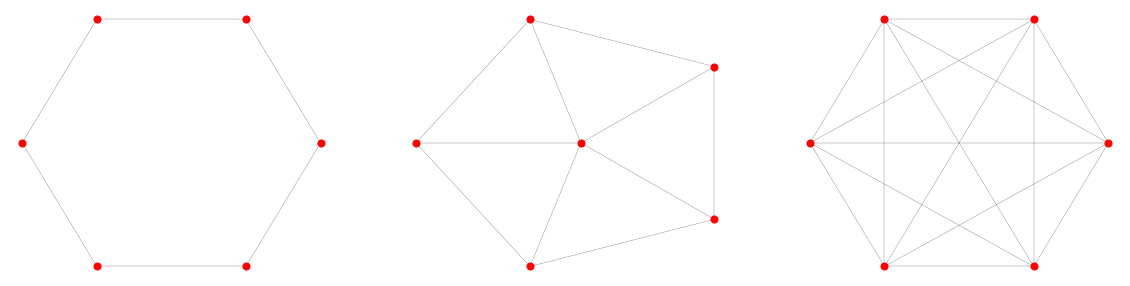

In [31]:
n_players = 6

ring_network = nx.watts_strogatz_graph(n_players, k=2, p=0)
wheel_network = nx.wheel_graph(n_players)
complete_network = nx.complete_graph(n_players)
networks = [ring_network, wheel_network, complete_network]

kwargs = {'width':0.2, 'node_size':50, 'with_labels':False, "node_color":"red"}
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i, network in enumerate(networks):
    nx.draw_kamada_kawai(network, ax=ax[i], **kwargs)

Hay dos (quizas tres) opciones a experimentar en cuanto a la implementacion del update bayesiano
1. La primera es la que implemento Diego: hacer que todos los agentes updateen una vez para cada exito y una vez para cada fracaso
2. La segunda es la que implemento Weisberg: con la ecuacion rara. 

Voy a empezar probando la version de Diego y despues la de Weisberg. Para poder evaluar las dos versiones, es importante que las creencias de los agentes se definan por fuera de la clase, de manera que pueda instanciar dos conjuntos de agentes con las mismas creencias y ver si evolucionan hacia las mismas creencias. Esto ademas me va a permitir calcular cuanto tiempo se toma cada implementacion para ver si deberia preferir alguna por sobre la otra en cuanto a temas de optimizacion.

Hay una potencial tercera alternativa que se desprenderia de la de Diego: la idea seria updatear solo por la diferencia entre fracasos y exitos. Si hubo mas fracasos que exitos, updatear con esa diferencia y con la probabilidad de obtener un fracaso dada la creencia. Si hubo mas exitos, lo mismo con likelihood invertido.

In [133]:
class Agent:
    def __init__(self, credence, num):
        self.num = num
        self.credence = credence
        self.n, self.k = 0, 0
        
    @property
    def is_experimenter(self):
        return self.credence > .5
    
    def experiment(self, n, p):
        if self.credence > .5:
            self.n = n
            self.k = np.random.binomial(n, p)
        else:
            self.n, self.k = 0, 0
            
    def bayesian_update(self, p_e_h, p_e_ch):
        self.credence = (p_e_h * self.credence) / ((p_e_h * self.credence) + (p_e_ch * (1-self.credence)))
        
class Simulation:
    def __init__(self, agents, network, proba_treatment):
        self.agents = list(agents.values())
        self.network = network
        nx.set_node_attributes(self.network, agents, 'player')
        self.proba_treatment = proba_treatment
        self.round = 0
    
    @property
    def experimenters(self):
        return [agent for agent in self.agents if agent.is_experimenter]
    
    @property
    def agent_credences(self):
        return np.array([agent.credence for agent in self.agents])
    
    def run_experiments(self):
        for agent in self.agents:
            agent.experiment(1000, self.proba_treatment)
    
    def step(self):
        self.run_experiments()
        for agent in self.agents:
            total_n, total_k = agent.n, agent.k
            for neighbor_num in self.network.neighbors(agent.num):
                total_n += self.agents[neighbor_num].n
                total_k += self.agents[neighbor_num].k
            fracasos = total_n - total_k
            for fracaso in range(fracasos):
                agent.bayesian_update(1-self.proba_treatment, self.proba_treatment)
            for exito in range(total_k):
                agent.bayesian_update(self.proba_treatment, 1-self.proba_treatment)
                
    def go(self):
        while any(self.experimenters) and not all(self.agent_credences>=.99):
            self.step()
            self.round += 1
            if self.round == 1000:
                break
        print(f'Después de {self.round} iteraciones, la simulación terminó.')

In [202]:
def debug_func(sim):
    print('Red:')
    kwargs = {'width':0.2, 'node_size':700, 'with_labels':True, "node_color":"red", "node_color":sim.agent_credences, "vmin":0, "vmax":1, "cmap":plt.cm.get_cmap('hot')}
    nx.draw_kamada_kawai(sim.network, **kwargs)
    # plt.colorbar()
    plt.show()
    print(f'Creencias iniciales de los agentes: {sim.agent_credences}')
    print(f'Los agentes experimentadores al comienzo son: {[experimenter.num for experimenter in sim.experimenters]}')
    print('---')
    print('Ronda de experimentos')
    sim.run_experiments()
    print(f'Resultados de los experimentos: {[experimenter.k for experimenter in sim.experimenters]}')
    print(f'n y k para el resto de los agentes: {[(agent.n, agent.k) for agent in sim.agents if agent not in sim.experimenters]}')
    for agent in sim.agents:
        print('---')
        print(f'Agente {agent.num}')
        print(f'Creencia incial: {agent.credence}')
        total_n, total_k = agent.n, agent.k
        for neighbor_num in sim.network.neighbors(agent.num):
            total_n += sim.agents[neighbor_num].n
            total_k += sim.agents[neighbor_num].k
        print(f'Total de experimentos realizados para el agente {agent.num} y sus vecinos: {total_n}')
        print(f'Total de exitos obtenidos para el agente {agent.num} y sus vecinos: {total_k}')
        fracasos = total_n - total_k
        print(f'Total fracasos: {fracasos}')
        for fracaso in range(fracasos):
            agent.bayesian_update(1-sim.proba_treatment, sim.proba_treatment)
        for exito in range(total_k):
            agent.bayesian_update(sim.proba_treatment, 1-sim.proba_treatment)
        print(f'Creencia resultante: {agent.credence}')

In [204]:
n_players=6
credences = np.random.uniform(0, 1, n_players)

Red:


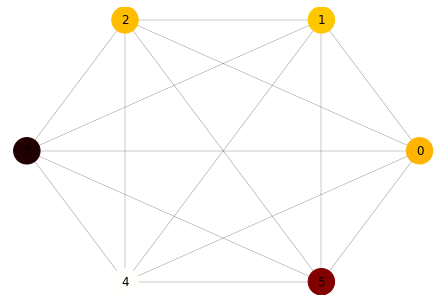

Creencias iniciales de los agentes: [0.63579724 0.66336966 0.6469663  0.03265576 0.99271881 0.18354517]
Los agentes experimentadores al comienzo son: [0, 1, 2, 4]
---
Ronda de experimentos
Resultados de los experimentos: [531, 522, 495, 508]
n y k para el resto de los agentes: [(0, 0), (0, 0)]
---
Agente 0
Creencia incial: 0.6357972400175923
Total de experimentos realizados para el agente 0 y sus vecinos: 4000
Total de exitos obtenidos para el agente 0 y sus vecinos: 2056
Total fracasos: 1944
Creencia resultante: 0.9935536016845399
---
Agente 1
Creencia incial: 0.6633696615111903
Total de experimentos realizados para el agente 1 y sus vecinos: 4000
Total de exitos obtenidos para el agente 1 y sus vecinos: 2056
Total fracasos: 1944
Creencia resultante: 0.9942850845064442
---
Agente 2
Creencia incial: 0.6469663015035344
Total de experimentos realizados para el agente 2 y sus vecinos: 4000
Total de exitos obtenidos para el agente 2 y sus vecinos: 2056
Total fracasos: 1944
Creencia resulta

In [206]:
agents = {i:Agent(credence, i) for i, credence in enumerate(credences)}
sim = Simulation(agents, complete_network, .505)
debug_func(sim)

In [208]:
def bayes_rule(ph, pch, peh, pech):
    return (peh*ph) / ((peh*ph) + (pech*pch))

In [237]:
n = 4000
exitos = 2056
fracasos = n - exitos
prior = .18354516791989772
posterior = prior

In [229]:
for fracaso in range(fracasos):
    posterior = bayes_rule(posterior, 1-posterior, .505, 1-.505)
for exito in range(exitos):
    posterior = bayes_rule(posterior, 1-posterior, .505, 1-.505)
    
posterior

0.9999999999999944

In [234]:
def bayes_update(prior, k, n, epsilon):
    return 1 / (1 + (1 - prior) * (((0.5 - epsilon) / (0.5 + epsilon)) ** (2 * k - n)) / prior)

In [238]:
posterior = bayes_update(prior, exitos, n, .05)

In [239]:
posterior

0.9999999992284403

# Experimentos para animar la evolución de la red

In [76]:
kwargs = {'width':0.2, 'node_size':50, 'with_labels':False}
colors = sim.agent_credences
def animate(i):
    sim.step()
    plt.cla()
    fig, ax = plt.subplots()
    nx.draw_kamada_kawai(sim.network, ax=ax, node_color=colors, vmin=0, vmax=1, cmap = plt.cm.get_cmap('rainbow'), **kwargs)
    
animation = FuncAnimation(fig, animate, interval=100)
plt.show()

In [70]:
animation = FuncAnimation(plt.gcf(), animate, interval=100)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

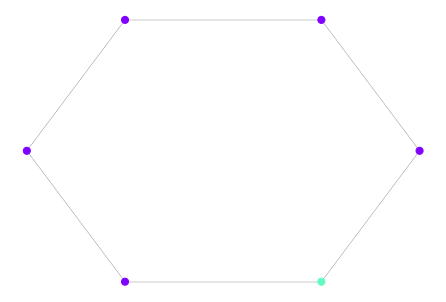

In [69]:
colors = sim.agent_credences
kwargs = {'width':0.2, 'node_size':50, 'with_labels':False}#, 'node_color':[i/n_players for i in range(n_players)]}
nx.draw_kamada_kawai(sim.network, **kwargs, node_color=colors, vmin=0, vmax=1, cmap = plt.cm.get_cmap('rainbow'))
plt.show()

# nx.draw(G, pos, node_color = nx.get_node_attributes(G,'val'), vmin=0, vmax=4, cmap = plt.cm.get_cmap('rainbow'))
# def animate(i):
#     nx.draw_kamada_kawai(sim.network, **kwargs)